In [1]:
"""
Follows https://www.tensorflow.org/tutorials/text/text_classification_rnn
"""
import pickle as pkl
import numpy as np
import random
import re

import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
from datetime import datetime
datetime.now()

datetime.datetime(2021, 1, 8, 16, 5, 28, 810718)

In [3]:
def plot_graphs(history, metric):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel(metric, color=color)
    ax1.plot(history.history[metric], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel("val_" + metric, color=color)  # we already handled the x-label with ax1
    ax2.plot(history.history["val_" + metric], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.legend([metric, "val_" + metric])

In [4]:
def split_data_into_input_and_output(data):
    """Take given data of format from scraper [link] and return the inputs and outputs seperated.

    Args:
        data (list): A numpy array/list of named tuples which contains entries for 'gross',
        'title', 'synopsis' and 'year'.
    """
    data_in, data_out = list(zip(*[((x["synopsis"]), x["gross"]) for x in data]))
    return np.array(data_in), np.array(data_out)

In [5]:
def add_signal(data):
    """
    If the given data has no signal we cant fit a NN to it. As such, here we append how much the film grossed
    into the synopsis of each title.

    Args:
        data (list): A numpy array/list of named tuples which contains entries for 'gross',
        'title', 'synopsis' and 'year'.
    """
    for row in data:
        row["synopsis"] = row["synopsis"] + f' The film grossed ${row["gross"]}'

In [6]:
def standardize(batch):
    '''
    Designed to seperate digits in number
    '''
    DEFAULT_REGEX = r'[!"#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']'
    # Remove any pennies/cents
    batch = tf.strings.regex_replace(batch, r'([\.|,][0-9].*)', '')
    # Normal punc strip
    batch = tf.strings.regex_replace(batch, DEFAULT_REGEX, "")
    # Spread out the values so we can get them frequent enough to appear in our vocab
    batch = tf.strings.regex_replace(batch, r'([0-9])', r'\1 ')
    return batch

In [7]:
real_data = pkl.load(open("complete10000_films_and_synopsis.pickle", "rb"))
add_signal(real_data)
np.random.shuffle(real_data[500:])
data = real_data

In [8]:
# Fraction of overall data
training_fraction = 0.85

train_end = int(len(data) * training_fraction)
train_data_in, train_data_out = split_data_into_input_and_output(data[:train_end])
test_data_in, test_data_out = split_data_into_input_and_output(data[train_end:])

train_dataset = tf.data.Dataset.from_tensor_slices((train_data_in, train_data_out))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_in, test_data_out))


# How much it loads into memory for sampling
BUFFER_SIZE = 10000
# Batch for gradient averaging
BATCH_SIZE = 64
# prefetch parrallelising loading + execution (not huge so not necessary)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(5)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(5)

In [9]:
sample, label = next(iter(train_dataset.take(1)))

In [10]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, ngrams=1, standardize=standardize
)


In [11]:
encoder.adapt(train_dataset.map(lambda text, label: text))

In [12]:
encoded_sample = encoder(sample).numpy()[:3]
print(encoded_sample)

[[  22   72   13  110  442   26  469 8493 2273   20    2  359  146   46
   368   27  178    4    6    7   10   12   19   16   10   14    5    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [  22 7397  678   11 1690 2493   24    3 4549  615    8   98   21  245
    28    2  222    4    6    7   17   14   17    5   18   14    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [  56 2264  228    3  652  233  106   28    2  278   27    2 1651  582
    32    3  195  817    4    6    7   10   18  

In [13]:
vocab = np.array(encoder.get_vocabulary())

for n in range(3):
  print("Original: ", sample[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_sample[n]]))
  print()

Original:  b'A father and daughter form an unlikely songwriting duo in the summer before she leaves for college. The film grossed $2386251.0'
Round-trip:  A father and daughter form an unlikely songwriting duo in the summer before she leaves for college The film grossed 2 3 8 6 2 5 1                                                          

Original:  b'A banished hero of Rome allies with a sworn enemy to take his revenge on the city. The film grossed $757195.0'
Round-trip:  A banished hero of Rome allies with a sworn enemy to take his revenge on the city The film grossed 7 5 7 1 9 5                                                           

Original:  b'An ex-cop, now a private detective, takes on the search for the millions stolen by a drug lord. The film grossed $29392418.0'
Round-trip:  An excop now a private detective takes on the search for the millions stolen by a drug lord The film grossed 2 9 3 9 2 4 1 8                                                        



In [14]:
model = tf.keras.Sequential(
    [
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.1),
)

In [15]:
history = model.fit(
    train_dataset, epochs=100, validation_data=test_dataset, validation_steps=len(test_data_in) // BATCH_SIZE
)

Epoch 1/100
133/133 [==============================] - 42s 314ms/step - loss: 3979423833391104.0000 - val_loss: 860546760966144.0000
Epoch 2/100
133/133 [==============================] - 36s 271ms/step - loss: 3644224452952064.0000 - val_loss: 885285973917696.0000
Epoch 3/100
133/133 [==============================] - 36s 268ms/step - loss: 3576796687630336.0000 - val_loss: 881862952091648.0000
Epoch 4/100
133/133 [==============================] - 38s 288ms/step - loss: 3557541007065088.0000 - val_loss: 899629084311552.0000
Epoch 5/100
133/133 [==============================] - 37s 281ms/step - loss: 3505244143091712.0000 - val_loss: 954789886164992.0000
Epoch 6/100
133/133 [==============================] - 36s 274ms/step - loss: 3481347750363136.0000 - val_loss: 929581984907264.0000
Epoch 7/100
133/133 [==============================] - 36s 274ms/step - loss: 3457724088057856.0000 - val_loss: 1107122511151104.0000
Epoch 8/100
133/133 [==============================] - 36s 273ms/ste

In [16]:
res = model.evaluate(test_dataset)

24/24 [==============================] - 2s 75ms/step - loss: 1834619842330624.0000


In [17]:
sample_text = "As a new threat to the galaxy rises, Rey, a desert scavenger, and Finn, an ex-stormtrooper, must join Han Solo and Chewbacca to search for the one hope of restoring peace."
pred1 = model.predict(np.array([sample_text]))
print(int(pred1[0]))

31809708


In [18]:
non_existant_film = "Este is a friend of mine we meet up every tuesday night for dinner and a glass of wine. She thinks he did it but just cant prove it"
pred2 = model.predict(np.array([non_existant_film]))
print(int(pred2[0]))

32149736


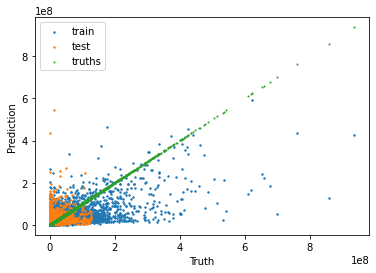

<Figure size 432x288 with 0 Axes>

In [19]:
test_predictions = model.predict(test_data_in)
train_predictions = model.predict(train_data_in)
plt.scatter(train_data_out, train_predictions, label='train', s=2)
plt.scatter(test_data_out, test_predictions, label='test', s=2)
plt.scatter(real_data['gross'], real_data['gross'], label='truths', s=1)
plt.legend()
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.show()
plt.savefig("exp_16.pdf", dpi=300)

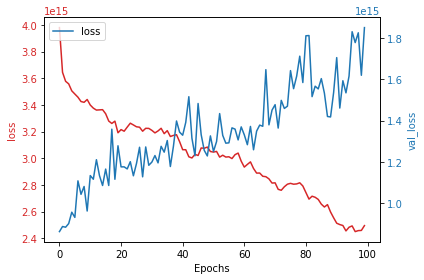

In [20]:
plot_graphs(history,'loss')
plt.savefig("exp_16_2.pdf", dpi=300)

In [21]:
import pickle as pkl
pkl.dump(history, open('exp_16.pkl','wb'))

TypeError: cannot pickle '_thread.RLock' object